<a href="https://colab.research.google.com/github/sankitanitdgp/30-seconds-of-cpp/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('drive/MyDrive/tools')

# os.listdir('runs10')

In [ ]:
writer1 = SummaryWriter('runs/resnetT10')
writer2 = SummaryWriter('runs/resnetV10')

# writer1 = SummaryWriter('runs/enT20')
# writer2 = SummaryWriter('runs/enV20')

# writer1 = SummaryWriter('runs/VGG16T20')
# writer2 = SummaryWriter('runs/VGG16V20')

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [ ]:
data_dir = "CNNImages"

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(classes)

tensor([3, 4, 2, 7, 2, 3, 1, 4, 6, 3, 4, 2, 6, 0, 4, 8, 6, 5, 1, 4, 1, 0, 0, 8,
        2, 3, 7, 4, 7, 0, 3, 7, 7, 7, 7, 2, 6, 0, 2, 7, 6, 6, 7, 6, 3, 5, 7, 2,
        7, 8, 2, 3, 5, 6, 6, 0, 4, 6, 8, 8, 6, 0, 4, 2])


In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

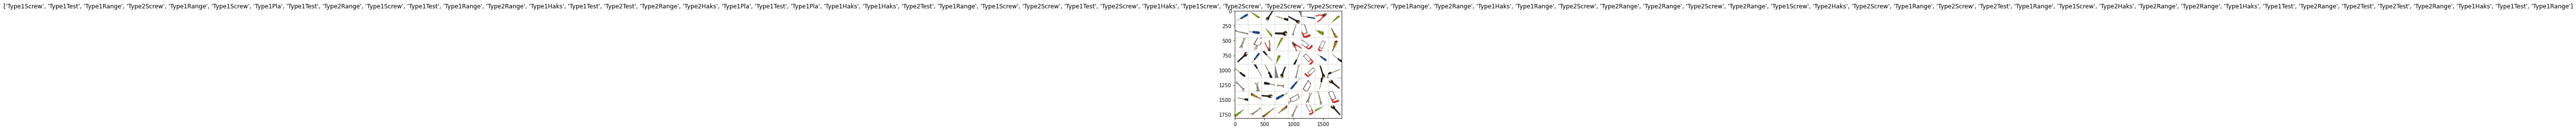

In [ ]:
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def plot(val_loss,train_loss,typ):
    plt.title("{} after epoch: {}".format(typ,len(train_loss)))
    plt.xlabel("Epoch")
    plt.ylabel(typ)
    plt.plot(list(range(len(train_loss))),train_loss,color="r",label="Train "+typ)
    plt.plot(list(range(len(val_loss))),val_loss,color="b",label="Validation "+typ)
    plt.legend()
    plt.savefig(os.path.join(data_dir,typ+".png"))
    plt.close()

In [ ]:
val_loss_gph=[]
train_loss_gph=[]
val_acc_gph=[]
train_acc_gph=[]

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,model_name = "kaggle"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, d in enumerate(tqdm(dataloaders[phase])):
                inputs = d[0].to(device)
                labels = d[1].to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #was (outputs,1) for non-inception and (outputs.data,1) for inception
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_gph.append(epoch_loss)
                train_acc_gph.append(epoch_acc)
                writer1.add_scalar('accuracy',
                            epoch_acc,
                            epoch)
            if phase == 'val':
                val_loss_gph.append(epoch_loss)
                val_acc_gph.append(epoch_acc)
                writer2.add_scalar('accuracy',
                            epoch_acc,
                            epoch)

            
            #plot(val_loss_gph,train_loss_gph, "Loss")
            #plot(val_acc_gph,train_acc_gph, "Accuracy")
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'Resnet_10_epochs.pth')
                print('==>Model Saved')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#model = torch.load('../Models/inception.h5')
# model = models.alexnet(pretrained=True)

model = models.resnet18(pretrained=True)
# model = models.efficientnet_b0(pretrained=True)
# model.aux_logits=False
model = model.cuda()

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_ftrs = model.fc.in_features

In [ ]:
print("Number of features: "+str(num_ftrs))

Number of features: 512


In [ ]:
model.fc = nn.Linear(num_ftrs, num_classes)
# model.classifier[1] = nn.Linear(num_ftrs, num_classes)
# model.classifier[1] = model.classifier[1].cuda() ## for vgg11
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10, model_name = "resnet")

Epoch 1/10
----------


100%|██████████| 32/32 [15:48<00:00, 29.66s/it]


train Loss: 0.1415 Acc: 0.9574


100%|██████████| 4/4 [02:39<00:00, 39.75s/it]


val Loss: 0.0501 Acc: 0.9921
==>Model Saved

Epoch 2/10
----------


100%|██████████| 32/32 [01:08<00:00,  2.15s/it]


train Loss: 0.0102 Acc: 0.9980


100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


val Loss: 0.0028 Acc: 1.0000
==>Model Saved

Epoch 3/10
----------


100%|██████████| 32/32 [01:09<00:00,  2.17s/it]


train Loss: 0.0036 Acc: 0.9995


100%|██████████| 4/4 [00:08<00:00,  2.15s/it]


val Loss: 0.0161 Acc: 0.9960

Epoch 4/10
----------


100%|██████████| 32/32 [01:11<00:00,  2.22s/it]


train Loss: 0.0668 Acc: 0.9817


100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


val Loss: 6.7062 Acc: 0.5476

Epoch 5/10
----------


100%|██████████| 32/32 [01:09<00:00,  2.16s/it]


train Loss: 0.0846 Acc: 0.9728


100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


val Loss: 3.8535 Acc: 0.6508

Epoch 6/10
----------


100%|██████████| 32/32 [01:10<00:00,  2.21s/it]


train Loss: 0.0574 Acc: 0.9851


100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


val Loss: 0.0034 Acc: 1.0000
==>Model Saved

Epoch 7/10
----------


100%|██████████| 32/32 [01:09<00:00,  2.17s/it]


train Loss: 0.0068 Acc: 0.9985


100%|██████████| 4/4 [00:08<00:00,  2.15s/it]


val Loss: 0.0012 Acc: 1.0000
==>Model Saved

Epoch 8/10
----------


100%|██████████| 32/32 [01:10<00:00,  2.19s/it]


train Loss: 0.0028 Acc: 0.9990


100%|██████████| 4/4 [00:08<00:00,  2.15s/it]


val Loss: 0.0031 Acc: 1.0000
==>Model Saved

Epoch 9/10
----------


100%|██████████| 32/32 [01:10<00:00,  2.22s/it]


train Loss: 0.0020 Acc: 0.9995


100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


val Loss: 0.0004 Acc: 1.0000
==>Model Saved

Epoch 10/10
----------


100%|██████████| 32/32 [01:09<00:00,  2.17s/it]


train Loss: 0.0010 Acc: 1.0000


100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


val Loss: 0.0001 Acc: 1.0000
==>Model Saved

Training complete in 30m 20s
Best val Acc: 1.000000


In [ ]:
# checkpoint = torch.load('../Models25/InceptionModel.pth')
# checkpoint = torch.load('EfficientSTACK.pth')
checkpoint = torch.load('Resnet_10_epochs.pth')
# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])
print('Previously trained model weights state_dict loaded...')
# load trained optimizer state_dict
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print('Previously trained optimizer state_dict loaded...')
# load the criterion
criterion = checkpoint['loss']
print('Trained model loss function loaded...')

RuntimeError: ignored

In [ ]:
# Getting Proba distribution
print("\nGetting the Probability Distribution")
testloader=torch.utils.data.DataLoader(image_datasets['test'],batch_size=1)


Getting the Probability Distribution


In [ ]:
model=model.eval()
correct = 0
total = 0
import csv
import numpy as np
f = open("resnet10epochs.csv",'w+',newline = '')
# f = open("Resnet50.csv",'w+',newline = '')
# f = open("EffNetB0_20epochs.csv",'w+',newline = '')

writer = csv.writer(f)

confusion_matrix_resnet = torch.zeros(num_classes, num_classes)
num_classes

9

In [ ]:
with torch.no_grad():
      num = 0
      temp_array = np.zeros((len(testloader),num_classes))
      for data in testloader:
          images, labels = data
          #labels=labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum().item()
          prob = torch.nn.functional.softmax(outputs, dim=1)
          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])
          num+=1
          for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix_resnet[t.long(), p.long()] += 1
print("Accuracy = ",100*correct/total)

Accuracy =  10.714285714285714


In [ ]:
confusion_matrix_resnet

tensor([[27.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0., 28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 28.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 28.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 28.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 28.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 28.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 28.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 28.]])